In [1]:
!nvidia-smi

Sun Aug  2 17:09:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url


## Setup Dataset

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o8j2VFM1F7WLe-xmDyb6iUu8NGA8hjUy' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1o8j2VFM1F7WLe-xmDyb6iUu8NGA8hjUy" -O drone-dataset.zip

--2020-08-02 17:09:58--  https://docs.google.com/uc?export=download&confirm=cxj_&id=1o8j2VFM1F7WLe-xmDyb6iUu8NGA8hjUy
Resolving docs.google.com (docs.google.com)... 142.250.13.100, 142.250.13.101, 142.250.13.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.13.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-3o-docs.googleusercontent.com/docs/securesc/fjsfgvi6b08s6kq42qn8g5fd9o03rv12/tt9t3piocjd3i0rru4vgg5lpigm15d5s/1596388125000/17277053519044670471/17109328566504353581Z/1o8j2VFM1F7WLe-xmDyb6iUu8NGA8hjUy?e=download [following]
--2020-08-02 17:09:58--  https://doc-00-3o-docs.googleusercontent.com/docs/securesc/fjsfgvi6b08s6kq42qn8g5fd9o03rv12/tt9t3piocjd3i0rru4vgg5lpigm15d5s/1596388125000/17277053519044670471/17109328566504353581Z/1o8j2VFM1F7WLe-xmDyb6iUu8NGA8hjUy?e=download
Resolving doc-00-3o-docs.googleusercontent.com (doc-00-3o-docs.googleusercontent.com)... 74.125.71.132, 2a00:1450:400c:c02::84
Connecting 

In [4]:
!unzip drone-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/processed-drone-dataset/train/0/image169.jpg  
  inflating: content/processed-drone-dataset/train/0/image (75).jpg  
  inflating: content/processed-drone-dataset/train/0/ANd9GcREQK6e0H-fMUEaRKwZbw-dRPOJdsZC1J8Qow.jpg  
  inflating: content/processed-drone-dataset/train/0/XBt0ucY6_-E.jpg  
  inflating: content/processed-drone-dataset/train/0/exotic-flying-bird-is-isolated-on-a-black-background-KDA8RM.jpg  
  inflating: content/processed-drone-dataset/train/0/image711.jpg  
  inflating: content/processed-drone-dataset/train/0/image43.jpg  
  inflating: content/processed-drone-dataset/train/0/040a2293b71be6b3abe4a2a04b89a763.jpg  
  inflating: content/processed-drone-dataset/train/0/E_9s8euT_fpSNc39vMaJIAHaEi.jpg  
  inflating: content/processed-drone-dataset/train/0/images173 (1).jpg  
  inflating: content/processed-drone-dataset/train/0/image69.jpg  
  inflating: content/processed-drone-dataset/train/0/1316233728127

In [5]:
!find . -name ".ipynb_checkpoints"  -delete

In [1]:
import os
data_dir = './content/processed-drone-dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['0', '1', '3', '2']


In [2]:
flyingbird_files = os.listdir(data_dir + "/train/0")
print('No. of training examples for flying birds:', len(flyingbird_files))
print(flyingbird_files[:5])


No. of training examples for flying birds: 5830
['74.jpg', 'EagleImage_11.jpg', 'pexels-photo-2266860.jpg', 'image133.jpg', 'couple-flying-doves-birds-sky-sunset-135875296.jpg']


In [3]:
largequad_test_files = os.listdir(data_dir + "/test/1")
print("No. of test examples for large quadcopter:", len(largequad_test_files))
print(largequad_test_files[:5])

No. of test examples for large quadcopter: 141
['i (20).jpg', 'firefighting-drones.jpg', '13.jpg', 'video16_194.jpg', 'Capture37.jpg']


### Transformations

In [4]:
import PIL
import torchvision.transforms as T

# [tensor(0.5270), tensor(0.5794), tensor(0.6113)]
# [tensor(0.1725), tensor(0.1665), tensor(0.1815)]
imagenet_stats = ([0.5270, 0.5794, 0.6113], [0.1725, 0.1665, 0.1815])

train_tfms = T.Compose([
    T.Resize( (224,224), interpolation=PIL.Image.BICUBIC), 
    T.RandomCrop(224, padding=8, padding_mode='reflect'),
  #  T.RandomResizedCrop(224, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    T.RandomRotation((-30,+30)), 
    T.ToTensor(),
    T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize( (224,224), interpolation=PIL.Image.BICUBIC),
    T.ToTensor(), 
    T.Normalize(*imagenet_stats)
])

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

trainset = ImageFolder(data_dir+'/train', transform=train_tfms)
testset  = ImageFolder(data_dir+'/test',  transform=valid_tfms)

In [6]:
img, label = trainset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[-3.0551, -3.0551, -3.0551,  ..., -3.0551, -3.0551, -3.0551],
         [-3.0551, -3.0551, -3.0551,  ..., -3.0551, -3.0551, -3.0551],
         [-3.0551, -3.0551, -3.0551,  ..., -3.0551, -3.0551, -3.0551],
         ...,
         [-3.0551, -3.0551, -3.0551,  ..., -3.0551, -3.0551, -3.0551],
         [-3.0551, -3.0551, -3.0551,  ..., -3.0551, -3.0551, -3.0551],
         [-3.0551, -3.0551, -3.0551,  ..., -3.0551, -3.0551, -3.0551]],

        [[-3.4799, -3.4799, -3.4799,  ..., -3.4799, -3.4799, -3.4799],
         [-3.4799, -3.4799, -3.4799,  ..., -3.4799, -3.4799, -3.4799],
         [-3.4799, -3.4799, -3.4799,  ..., -3.4799, -3.4799, -3.4799],
         ...,
         [-3.4799, -3.4799, -3.4799,  ..., -3.4799, -3.4799, -3.4799],
         [-3.4799, -3.4799, -3.4799,  ..., -3.4799, -3.4799, -3.4799],
         [-3.4799, -3.4799, -3.4799,  ..., -3.4799, -3.4799, -3.4799]],

        [[-3.3680, -3.3680, -3.3680,  ..., -3.3680, -3.3680, -3.3680],
         [-3.3680, -3.3680, -3.3680,  ..., -3

In [7]:
print(trainset.classes, len(trainset))

['0', '1', '2', '3'] 11375


In [8]:
print(testset.classes, len(testset))

['0', '1', '2', '3'] 4659


In [9]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  0 (0)


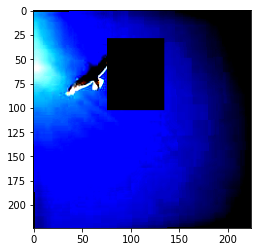

In [10]:
show_example(*trainset[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  3 (3)


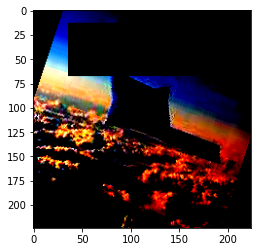

In [11]:
show_example(*trainset[11374])

In [12]:
# mean = [0,0,0]
# std  = [0,0,0]

# for data in dataset:
#   img, label = data
#   mean[0] += img[0,:,:].mean() 
#   mean[1] += img[1,:,:].mean() 
#   mean[2] += img[2,:,:].mean()
#   std[0] += img[0,:,:].std() 
#   std[1] += img[1,:,:].std() 
#   std[2] += img[2,:,:].std()
# mean[0] /= len(dataset)
# mean[1] /= len(dataset)
# mean[2] /= len(dataset)
# std[0] /= len(dataset)
# std[1] /= len(dataset)
# std[2] /= len(dataset)
# print(mean)
# print(std)
# # [tensor(0.5270), tensor(0.5794), tensor(0.6113)]
# # [tensor(0.1725), tensor(0.1665), tensor(0.1815)]

## Training and Validation Dataset

In [13]:
import torch

random_seed = 42
torch.manual_seed(random_seed);

In [14]:
# from torch.utils.data import random_split
# val_size = 1148
# train_size = len(dataset) - val_size

# train_ds, val_ds = random_split(dataset, [train_size, val_size])
# len(train_ds), len(val_ds)

In [15]:
from torch.utils.data.dataloader import DataLoader

batch_size=256

train_dl = DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(testset, batch_size, num_workers=4, pin_memory=True)

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


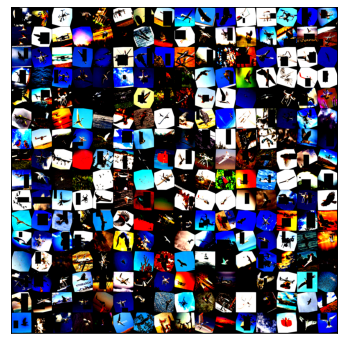

In [17]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


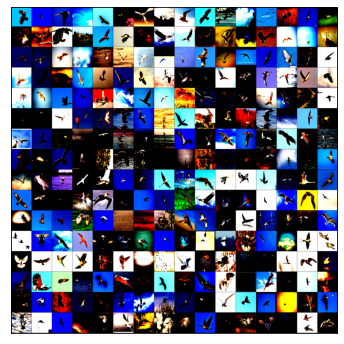

In [18]:
show_batch(val_dl)

## Model - Transfer Learning

In [19]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class DroneClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_score': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_score'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [20]:
class DroneMobilenetV2(DroneClassificationBase):
    def __init__(self):
        super().__init__()
        # Use ROIpoolng to resize image to 224*224
        # self.ROIpool = nn.AdaptiveMaxPool2d((224,224))
        # Use a pretrained MobilenetV2 model
        self.network = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier[1] = nn.Linear(num_ftrs, 4)
    
    def forward(self, xb):
        # resized = self.ROIpool(xb)
        out     = self.network(xb)
        return F.log_softmax(out, dim=1)
#         return torch.sigmoid(self.fc(self.relu(self.network(xb))))

    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.classifier[1].parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
model = DroneMobilenetV2()
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


DroneMobilenetV2(
  (network): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias

## Training

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay, momentum=0.9)
    # optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    #sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, base_momentum = 0.8, steps_per_epoch=len(train_loader))
    #sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2 )
    sched = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=max_lr, base_lr=0.00001, step_size_up=50, step_size_down=len(train_loader)*3)
    best_acc = 0.9346137046813965
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            
            sched.step()
            
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        if best_acc < result['val_score'] :
            best_acc = result['val_score']
            torch.save(model.state_dict(), 'best-epoch2.pth')
        history.append(result)
    print(f'best accuracy = {best_acc}')
    return history

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model  = to_device(DroneMobilenetV2(), device);
# model.load_state_dict(torch.load('best-epoch21.pth'))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [26]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.466616153717041, 'val_score': 0.16467927396297455}]

In [27]:
model.freeze()

In [28]:
from tqdm.notebook import tqdm
%matplotlib inline

epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [29]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0088, train_loss: 0.7145, val_loss: 0.3538, val_score: 0.8785



Epoch [1], last_lr: 0.0071, train_loss: 0.3372, val_loss: 0.2715, val_score: 0.9038



Epoch [2], last_lr: 0.0038, train_loss: 0.2801, val_loss: 0.2304, val_score: 0.9151



Epoch [3], last_lr: 0.0005, train_loss: 0.2562, val_loss: 0.2185, val_score: 0.9217



Epoch [4], last_lr: 0.0078, train_loss: 0.2401, val_loss: 0.2228, val_score: 0.9204



Epoch [5], last_lr: 0.0075, train_loss: 0.2348, val_loss: 0.2044, val_score: 0.9266



Epoch [6], last_lr: 0.0042, train_loss: 0.2191, val_loss: 0.1965, val_score: 0.9346



Epoch [7], last_lr: 0.0008, train_loss: 0.1952, val_loss: 0.1862, val_score: 0.9336



Epoch [8], last_lr: 0.0068, train_loss: 0.1881, val_loss: 0.2178, val_score: 0.9190



Epoch [9], last_lr: 0.0079, train_loss: 0.1919, val_loss: 0.1920, val_score: 0.9340
best accuracy = 0.9346137046813965
CPU times: user 1min 30s, sys: 59.1 s, total: 2min 29s
Wall time: 7min 33s


In [31]:
model.unfreeze()

In [32]:
%%time
history += fit_one_cycle(10, 0.005, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=1e-5, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0044, train_loss: 0.1738, val_loss: 0.1803, val_score: 0.9377



Epoch [1], last_lr: 0.0036, train_loss: 0.1700, val_loss: 0.1792, val_score: 0.9437



Epoch [2], last_lr: 0.0019, train_loss: 0.1559, val_loss: 0.1778, val_score: 0.9443



Epoch [3], last_lr: 0.0002, train_loss: 0.1438, val_loss: 0.1730, val_score: 0.9451



Epoch [4], last_lr: 0.0039, train_loss: 0.1444, val_loss: 0.1756, val_score: 0.9445



Epoch [5], last_lr: 0.0037, train_loss: 0.1450, val_loss: 0.1866, val_score: 0.9418



Epoch [6], last_lr: 0.0021, train_loss: 0.1408, val_loss: 0.1734, val_score: 0.9474



Epoch [7], last_lr: 0.0004, train_loss: 0.1350, val_loss: 0.1772, val_score: 0.9472



Epoch [8], last_lr: 0.0034, train_loss: 0.1285, val_loss: 0.1765, val_score: 0.9445



Epoch [9], last_lr: 0.0039, train_loss: 0.1312, val_loss: 0.1969, val_score: 0.9451
best accuracy = 0.9473603963851929
CPU times: user 1min 30s, sys: 59.3 s, total: 2min 29s
Wall time: 7min 36s


In [33]:
%%time
history += fit_one_cycle(10, 0.0005, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=0, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0004, train_loss: 0.1269, val_loss: 0.1729, val_score: 0.9478



Epoch [1], last_lr: 0.0004, train_loss: 0.1242, val_loss: 0.1722, val_score: 0.9476



Epoch [2], last_lr: 0.0002, train_loss: 0.1236, val_loss: 0.1718, val_score: 0.9486



Epoch [3], last_lr: 0.0000, train_loss: 0.1205, val_loss: 0.1719, val_score: 0.9482



Epoch [4], last_lr: 0.0004, train_loss: 0.1226, val_loss: 0.1701, val_score: 0.9494



Epoch [5], last_lr: 0.0004, train_loss: 0.1195, val_loss: 0.1704, val_score: 0.9496



Epoch [6], last_lr: 0.0002, train_loss: 0.1114, val_loss: 0.1706, val_score: 0.9484



Epoch [7], last_lr: 0.0000, train_loss: 0.1159, val_loss: 0.1705, val_score: 0.9494



Epoch [8], last_lr: 0.0003, train_loss: 0.1191, val_loss: 0.1704, val_score: 0.9496



Epoch [9], last_lr: 0.0004, train_loss: 0.1175, val_loss: 0.1712, val_score: 0.9484
best accuracy = 0.9496219158172607
CPU times: user 1min 26s, sys: 58.7 s, total: 2min 25s
Wall time: 7min 27s


In [34]:
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=0, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0001, train_loss: 0.1158, val_loss: 0.1703, val_score: 0.9498



Epoch [1], last_lr: 0.0001, train_loss: 0.1184, val_loss: 0.1705, val_score: 0.9486



Epoch [2], last_lr: 0.0000, train_loss: 0.1149, val_loss: 0.1706, val_score: 0.9486



Epoch [3], last_lr: 0.0000, train_loss: 0.1139, val_loss: 0.1713, val_score: 0.9498



Epoch [4], last_lr: 0.0001, train_loss: 0.1131, val_loss: 0.1701, val_score: 0.9496



Epoch [5], last_lr: 0.0001, train_loss: 0.1122, val_loss: 0.1704, val_score: 0.9506



Epoch [6], last_lr: 0.0000, train_loss: 0.1213, val_loss: 0.1704, val_score: 0.9492



Epoch [7], last_lr: 0.0000, train_loss: 0.1126, val_loss: 0.1700, val_score: 0.9500



Epoch [8], last_lr: 0.0001, train_loss: 0.1169, val_loss: 0.1712, val_score: 0.9494



Epoch [9], last_lr: 0.0001, train_loss: 0.1185, val_loss: 0.1705, val_score: 0.9500
best accuracy = 0.9506498575210571
CPU times: user 1min 27s, sys: 58.9 s, total: 2min 26s
Wall time: 7min 32s


In [35]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('accuracy vs. No. of epochs');

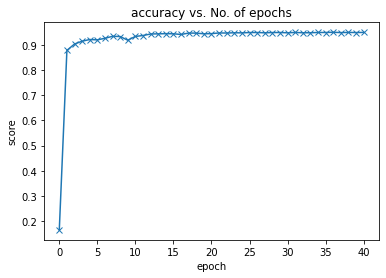

In [36]:
plot_scores(history)

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

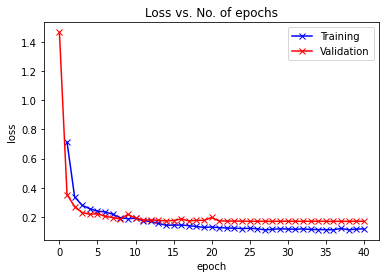

In [38]:
plot_losses(history)

In [39]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

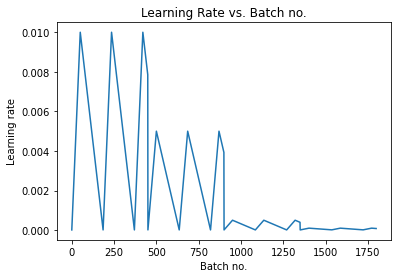

In [40]:
plot_lrs(history)

In [41]:
traced_model = torch.jit.trace(model.cpu(),torch.randn(1,3,224,224))

In [42]:
traced_model.save('DC_MobilenetV2.pt')